#Import dan Extract Data

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 87% 41.0M/47.0M [00:01<00:00, 21.9MB/s]
100% 47.0M/47.0M [00:01<00:00, 25.5MB/s]


In [ ]:
! unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

# Split Data

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
# membagi data menjadi train (80%) dan validasi (20%)
splitfolders.ratio("/content/Shoe vs Sandal vs Boot Dataset", output="/content/Shoe vs Sandal vs Boot Dataset",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 15000 files [00:01, 8681.92 files/s]


In [ ]:
train_dir = '/content/Shoe vs Sandal vs Boot Dataset/train'
validation_dir = '/content/Shoe vs Sandal vs Boot Dataset/val'

#Image Augmentation dan Load Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    zoom_range = 0.2,
                    horizontal_flip=True,
                    shear_range = 0.2)

validation_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical',
        shuffle = True)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


# Modeling dan Training

In [ ]:
model = tf.keras.models.Sequential([
    # menggunakan 4 lapis layer konvolusi dan max pooling.
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
# membuat callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')>0.97):
      print("\nAkurasi telah mencapai >97%!")
      self.model.stop_training = True

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=35,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=15,
      callbacks = myCallback(),
      verbose=2)

Epoch 1/50
35/35 - 28s - loss: 0.9820 - accuracy: 0.5089 - val_loss: 0.6614 - val_accuracy: 0.7437 - 28s/epoch - 803ms/step
Epoch 2/50
35/35 - 13s - loss: 0.7647 - accuracy: 0.6594 - val_loss: 0.6514 - val_accuracy: 0.7021 - 13s/epoch - 360ms/step
Epoch 3/50
35/35 - 13s - loss: 0.6265 - accuracy: 0.7429 - val_loss: 0.5826 - val_accuracy: 0.7906 - 13s/epoch - 364ms/step
Epoch 4/50
35/35 - 14s - loss: 0.5291 - accuracy: 0.7867 - val_loss: 0.4247 - val_accuracy: 0.8365 - 14s/epoch - 386ms/step
Epoch 5/50
35/35 - 13s - loss: 0.4769 - accuracy: 0.8125 - val_loss: 0.3618 - val_accuracy: 0.8583 - 13s/epoch - 361ms/step
Epoch 6/50
35/35 - 13s - loss: 0.4137 - accuracy: 0.8362 - val_loss: 0.3091 - val_accuracy: 0.8948 - 13s/epoch - 358ms/step
Epoch 7/50
35/35 - 13s - loss: 0.3552 - accuracy: 0.8536 - val_loss: 0.2990 - val_accuracy: 0.8969 - 13s/epoch - 358ms/step
Epoch 8/50
35/35 - 12s - loss: 0.3865 - accuracy: 0.8474 - val_loss: 0.2656 - val_accuracy: 0.9094 - 12s/epoch - 352ms/step
Epoch 9/

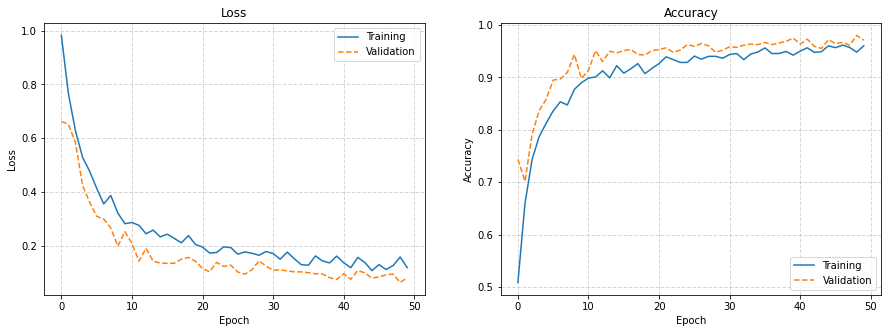

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training')
plt.plot(val_accuracy, label='Validation', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

Saving shoe test.jpeg to shoe test.jpeg
1/1 [==============================] - 0s 15ms/step
shoe test.jpeg
Gambar adalah "Shoe"


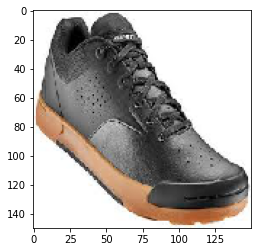

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
    path = fn
    img = image.load_img(path, target_size=(150,150))

    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)
    print(fn)
    if classes[0][0]!=0:
      print('Gambar adalah "Boot"')
    elif classes[0][1]!=0:
      print('Gambar adalah "Sandal"')
    else:
      print('Gambar adalah "Shoe"')